In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

import numpy
import torch
from time import time
from tqdm import tqdm

/usr/local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
cwd = os.getcwd()
NOTEBOOK_DIR = os.path.dirname(cwd+'/')
ROOT = os.path.dirname(NOTEBOOK_DIR)

import sys
sys.path.append(ROOT)

In [4]:
from utils.tools import *

# Constants

In [5]:
INPUT_DIM = 2 #50
BIAS = False

SEED = 42
N_TRAIN = 256
BATCH_SIZE = 64
ALPHA = 1e-1
BASE_LR = 1.0e-2
N_STEPS = int(1.5e3)
N_VAL = 100
VAL_ITER = 100
N_MAX_NEURONS = 2000

EPS = 1.0e-7
ALPHA = 0.1
BETA = 1.0
LAMBDA = 0.0 #0.01
TAU = 1.0

In [6]:
FIGURES_DIR = os.path.join(ROOT, 'figures/kernel_penalty_variants/')
create_dir(FIGURES_DIR)

In [7]:
set_random_seeds(SEED)

## Common functions

In [8]:
def forward(a, b, x):
    m = a.shape[1]
    if m == 0:
        return 0.
    return np.matmul(np.maximum(np.matmul(x, b.T), 0), a.T) #/ a.shape[1]

In [9]:
def H(c, u, kappa, sigma=1.0):
    if kappa == 'kappa_1':
        kappa = kappa_1
    elif kappa == 'kappa_2':
        kappa = kappa_2
    elif kappa == 'kappa_3':
        kappa = kappa_3
    else:
        kappa = kappa_1
    gram_mat = np.matmul(u, u.T)
    K = kappa(gram_mat, sigma=sigma)
    return 0.5 * np.matmul(np.abs(c), np.matmul(K, np.abs(c.T)))

In [10]:
# ATTRACTIVE
def kappa_1(s, sigma=1.0):
    return 1 - np.exp((s - 1) / sigma**2)

In [11]:
# REPULSIVE
def kappa_3(s, sigma=1.0):
    return np.exp((s - 1) / sigma**2)

In [1112]:
def projected_conic_update(x, y, c, u, kappa, sigma=1.0, penalty=True):
    if kappa == 'kappa_1':
        grad_sign = -1.0
        kappa = kappa_1
    elif kappa == 'kappa_3':
        grad_sign = 1.0
        kappa = kappa_3
    else:
        grad_sign = 1.0
    signs = np.sign(c)    
    y_hat = forward(c, u, x)
    n = x.shape[0]
    
    gram_mat = np.matmul(u, u.T)
    K = kappa(gram_mat, sigma=sigma)
    
    # mass updates
    grad_H = np.matmul(np.abs(c), K)
    grad_J = np.matmul((y_hat - y).T, np.maximum(np.matmul(x, u.T), 0)) / n
    grad = TAU * signs * grad_J # signs for the data-fitting term
    if penalty:
        grad += LAMBDA * grad_H
    grad_norm = np.mean(np.linalg.norm(grad, axis=1, ord=2, keepdims=True))
    grad = (grad / grad_norm) * np.minimum(grad_norm, 0.001)
    c = (1 - 2 * ETA * grad) * c  # no sign here since only the absolute values of the masses interact in the penalty
    
    # position updates
    grad_H = grad_sign * (1 / sigma**2) * (np.matmul(np.abs(c) * K, u) - np.matmul(K * gram_mat, np.abs(c).T) * u)
    #grad_H = -(1 / sigma**2) * (np.matmul(c * K, u) - np.matmul(K * gram_mat, c.T) * u)
    #grad_H = (1 / sigma**2) * (np.matmul(np.abs(c) * K, u) - np.matmul(K * gram_mat, np.abs(c.T)) * u)
    grad_J = np.matmul(np.heaviside(np.matmul(u, x.T), 0), (y_hat - y)*x) / n
    grad = TAU * signs.T * grad_J
    
    if penalty:
        grad += LAMBDA * grad_H
    grad_norm = np.mean(np.linalg.norm(grad, axis=1, ord=2, keepdims=True))
    grad = (grad / grad_norm) * np.minimum(grad_norm, 0.001)
    
    u = u - ETA * grad
    
    # re-normalize particle positions on the sphere
    u = u / np.linalg.norm(u, axis=1, ord=2, keepdims=True)
    
    return c, u, grad

In [1102]:
################################################################
######################### MODIFIED #############################
################################################################
def projected_conic_update(x, y, c, u, kappa, sigma=1.0, penalty=True):
    if kappa == 'kappa_1':
        grad_sign = -1.0
        kappa = kappa_1
    elif kappa == 'kappa_3':
        grad_sign = 1.0
        kappa = kappa_3
    else:
        grad_sign = 1.0
    signs = np.sign(c)    
    y_hat = forward(c, u, x)
    n = x.shape[0]
    
    gram_mat = np.matmul(u, u.T)
    K = kappa(gram_mat, sigma=sigma)
    
    # mass updates
    grad_H = np.matmul(np.abs(c), K)
    grad_J = np.matmul((y_hat - y).T, np.maximum(np.matmul(x, u.T), 0)) / n
    grad = TAU * signs * grad_J
    if penalty:
        grad +=  LAMBDA * grad_H  # signs for the data-fitting term
    grad_norm = np.mean(np.linalg.norm(grad, axis=1, ord=2, keepdims=True))
    grad = (grad / grad_norm) * np.minimum(grad_norm, 0.001)
    c = (1 + 2 * ETA * grad) * c  # no sign here since only the absolute values of the masses interact in the penalty
    
################################################################
######################### MODIFIED #############################
################################################################
    
    # position updates
    grad_H = grad_sign * (1 / sigma**2) * (np.matmul(np.abs(c) * K, u) - np.matmul(K * gram_mat, np.abs(c).T) * u)
    #grad_H = -(1 / sigma**2) * (np.matmul(c * K, u) - np.matmul(K * gram_mat, c.T) * u)
    #grad_H = (1 / sigma**2) * (np.matmul(np.abs(c) * K, u) - np.matmul(K * gram_mat, np.abs(c.T)) * u)
    grad_J = np.matmul(np.heaviside(np.matmul(u, x.T), 0), (y_hat - y)*x) / n
    grad = TAU * signs.T * grad_J
    
    if penalty:
        grad += LAMBDA * grad_H
    grad_norm = np.mean(np.linalg.norm(grad, axis=1, ord=2, keepdims=True))
    grad = (grad / grad_norm) * np.minimum(grad_norm, 0.001)
    
    u = u + ETA * grad
    
    # re-normalize particle positions on the sphere
    u = u / np.linalg.norm(u, axis=1, ord=2, keepdims=True)
    
    return c, u, grad

In [644]:
def remove_neurons(c, u, eps=1e-4):            
    squared_dists = 2 * (1 - np.matmul(u, u.T))  # vectors in u are of unit norm
    squared_dists += np.identity(len(squared_dists))
    dist_indexes_to_remove = np.argwhere(squared_dists < (eps**2))
    
    if len(dist_indexes_to_remove) > 0:
        cpt = 0
        i0, j = dist_indexes_to_remove[0]
        to_merge = {i0 : []}
        merged = set([i0])
        for k in range(len(dist_indexes_to_remove)):
            i, j = dist_indexes_to_remove[k]
            if i == i0:
                to_merge[i0].append(j)
                merged.add(j)
            else:
                if i not in merged:
                    i0 = i
                    merged.add(i)
                    to_merge[i] = []
                    if j not in merged:
                        to_merge[i].append(j)
                        merged.add(i)
                        merged.add(j)
        
        index_to_remove = []
        for i, js in to_merge.items():
            index_to_remove += js
            if len(js) > 0:
                c[0, i] += np.sum(c[0, js])

        u = np.delete(u, index_to_remove, axis=0)
        c = np.delete(c, index_to_remove, axis=1)
    
    return c, u

In [1113]:
def add_neuron(c, u, x, y, kappa, penalty=False):
    new_u = np.random.normal(size=(1, INPUT_DIM))
    new_u = new_u / np.linalg.norm(new_u, axis=1, ord=2, keepdims=True)

    if kappa == 'kappa_1':
        grad_sign = -1.0
        kappa = kappa_1
    elif kappa == 'kappa_3':
        grad_sign = 1.0
        kappa = kappa_3
    else:
        grad_sign = 1.0

    n = x.shape[0]
    if (c is None) or (u is None):
        # mass update
        y_hat = 0
        grad_J = np.matmul((y_hat - y).T, np.maximum(np.matmul(x, new_u.T), 0)) / n
        #grad = TAU * grad_J
        grad = grad_J
        
        #c = - ALPHA * (grad + np.random.normal(size=grad.shape))
        c = - ALPHA * grad
        u = new_u
    
    else:    
        y_hat = forward(c, u, x)
        signs = np.sign(c)    
        gram_mat = np.matmul(u, new_u.T)
        K = kappa(gram_mat, sigma=sigma)

        # mass updates
        if penalty:
            grad_H = np.matmul(np.abs(c), K)
        else:
            grad_H = 0
        grad_J = np.matmul((y_hat - y).T, np.maximum(np.matmul(x, new_u.T), 0)) / n

        grad = TAU * grad_J + LAMBDA * grad_H  # signs for the data-fitting term
        
        grad_norm = np.mean(np.linalg.norm(grad, axis=1, ord=2, keepdims=True))
        grad = (grad / grad_norm) * np.minimum(grad_norm, 0.02)

        new_c = - ALPHA * grad
        c = np.hstack((c, new_c))
        u = np.vstack((u, new_u))
    return c, u

In [1103]:
################################################################
######################### MODIFIED #############################
################################################################
def add_neuron(c, u, x, y, kappa, penalty=False):
    new_u = np.random.normal(size=(1, INPUT_DIM))
    new_u = new_u / np.linalg.norm(new_u, axis=1, ord=2, keepdims=True)

    if kappa == 'kappa_1':
        grad_sign = -1.0
        kappa = kappa_1
    elif kappa == 'kappa_3':
        grad_sign = 1.0
        kappa = kappa_3
    else:
        grad_sign = 1.0

    n = x.shape[0]
    if (c is None) or (u is None):
        # mass update
        y_hat = 0
        grad_J = np.matmul((y_hat - y).T, np.maximum(np.matmul(x, new_u.T), 0)) / n
        #grad = TAU * grad_J
        grad = grad_J
        
        #c = - ALPHA * (grad + np.random.normal(size=grad.shape))
        #c = - ALPHA * grad
        c = ALPHA * grad
        u = new_u
    
    
################################################################
######################### MODIFIED #############################
################################################################
    else:    
        y_hat = forward(c, u, x)
        signs = np.sign(c)    
        gram_mat = np.matmul(u, new_u.T)
        K = kappa(gram_mat, sigma=sigma)

        # mass updates
        if penalty:
            grad_H = np.matmul(np.abs(c), K)
        else:
            grad_H = 0
        grad_J = np.matmul((y_hat - y).T, np.maximum(np.matmul(x, new_u.T), 0)) / n

        grad = TAU * grad_J + LAMBDA * grad_H  # signs for the data-fitting term
        
        grad_norm = np.mean(np.linalg.norm(grad, axis=1, ord=2, keepdims=True))
        grad = (grad / grad_norm) * np.minimum(grad_norm, 0.001)

        #new_c = - ALPHA * grad
        new_c = ALPHA * grad
        c = np.hstack((c, new_c))
        u = np.vstack((u, new_u))
    return c, u

## Data

In [218]:
INPUT_DIM = 10 # 10
noise = 1e-5

m_star = 50
a_star = np.random.normal(size=(1, m_star))
b_star = np.random.normal(size=(m_star, INPUT_DIM)) / np.sqrt(INPUT_DIM)

n_train = 50
x_train = np.random.normal(size=(n_train, INPUT_DIM))
x_train = x_train / np.linalg.norm(x_train, axis=1, ord=2, keepdims=True)
y_train = forward(a_star, b_star, x_train) / m_star + noise * np.random.normal(size=(n_train, 1))

n_val = 50
x_val = np.random.normal(size=(n_val, INPUT_DIM))
x_val = x_val / np.linalg.norm(x_val, axis=1, ord=2, keepdims=True)
y_val = forward(a_star, b_star, x_val) / m_star + noise * np.random.normal(size=(n_val, 1))

## Training

In [1114]:
def train(c, u, kappa, sigma=1.0, eps=1e-4, conic=False, dynamic=True, n_updates=1, pop_penalty=False, pop=True, 
          penalty=True):
    us = [u]
    cs = [c]
    m0 = c.shape[1]
    ms = [c.shape[1]]
    y_hat = forward(c, u, x_train)
    y_hats = [y_hat]
    
    loss = TAU * np.mean((y_hat - y_train)**2) /2
    losses = [loss]
    penalized_losses = [loss + LAMBDA * H(c, u, kappa, sigma)[0, 0]]
    grads = []
    
    for k in range(N_STEPS // n_updates):
        if pop:
            if conic:
                if c.shape[1] < N_MAX_NEURONS:
                    if k % 2 == 0:
                        c, u = add_neuron(c, u, x_train, y_train, kappa, penalty=pop_penalty)
                    else:      
                        for _ in range(n_updates):
                            c, u, grad = projected_conic_update(x_train, y_train, c, u, kappa=kappa, sigma=sigma, 
                                                                penalty=penalty)
                            grads.append(grad)
                        if dynamic:
                            c, u = remove_neurons(c, u, eps=eps)
#                        if c.shape[1] < m0:
#                            c, u = add_neuron(c, u, x_train, y_train, kappa, penalty)

            else:
                c, u = add_neuron(c, u, x_train, y_train, kappa, penalty=pop_penalty)
                        
        else:
            for _ in range(n_updates):
                c, u, grad = projected_conic_update(x_train, y_train, c, u, kappa=kappa, sigma=sigma, penalty=penalty)

        
            if dynamic:
                c, u = remove_neurons(c, u, eps=eps)
                if conic:
                    if c.shape[1] < m0:
                        c, u = add_neuron(c, u, x_train, y_train, kappa, penalty=pop_penalty)
                    
        ms.append(c.shape[1])
        
        y_hat = forward(c, u, x_train)
        loss = TAU * np.mean((y_hat - y_train)**2) / 2
        penalized_loss = loss + LAMBDA * H(c, u, kappa, sigma)[0, 0]
        y_hats.append(y_hat)
        
        cs.append(c)
        us.append(u)
        losses.append(loss)
        penalized_losses.append(penalized_loss)
        
    return cs, us, np.array(losses), np.array(penalized_losses), ms, y_hats, grads

In [1115]:
def validation(c, u, conic=False):
    y_hat = forward(c, u, x_val)
    loss = TAU * np.mean((y_hat - y_val)**2) / 2
    if conic:
        penalized_loss = loss
    else:
        penalized_loss = loss + LAMBDA * H(c, u, kappa, sigma)[0, 0]
    return loss, penalized_loss

## 1. Usual pop-conic with and without penalty

In [1116]:
# REPULSIVE makes more sense as the pop step does not increase the penalized loss
N_MAX_NEURONS = 3000
ETA = 0.01
sigma = 0.35 # 0.3
N_STEPS = 3000 #3000
eps = 0.2 # 0.6
n_updates = 1

TAU = 0.0001 #1.0
ALPHA = 1.0 ## ---> CRUCIAL !!
LAMBDA = 1.0 # 1.0, 0.5
kappa = 'kappa_1' # 'kappa_3'

# POP-CONIC-PENALTY
pop_penalty = True
dynamic = True
pop = True
conic = True
penalty = True
c0_, u0_ = add_neuron(None, None, x_train, y_train, kappa)
c, u, losses3, penalized_losses3, ms3, _, grads = \
        train(c0_, u0_, kappa=kappa, sigma=sigma, eps=eps, n_updates=n_updates, 
              conic=conic, dynamic=dynamic, pop_penalty=pop_penalty, pop=pop, penalty=penalty)
#        train(c0, u0, kappa='kappa_1', sigma=sigma, eps=eps, dynamic=dynamic, n_updates=n_updates, penalty=penalty)

# POP-CONIC
#pop_penalty = False
#dynamic = True
#pop = True
#conic = True
#penalty = False
#c, u, losses_pop, penalized_losses_pop, ms_pop, _ = \
#        train(c0_, u0_, kappa=kappa, sigma=sigma, eps=eps, n_updates=n_updates, 
#              conic=conic, dynamic=dynamic, pop_penalty=pop_penalty, pop=pop, penalty=penalty)

In [1117]:
grad_norms = [np.mean(np.linalg.norm(grad_, axis=1, ord=2, keepdims=True)) for grad_ in grads]

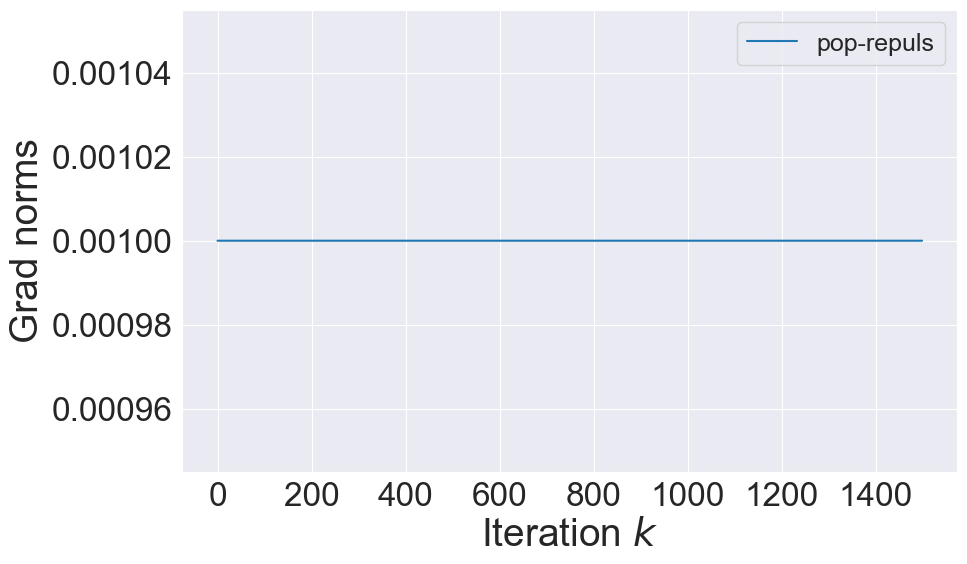

In [1118]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

plt.plot(np.arange(len(grad_norms)), grad_norms, label='pop-repuls')
#plt.plot(np.arange(len(train_losses_mix_conic)), train_losses_mix_conic, label='mix-conic')

plt.xlabel('Iteration $k$', fontsize=28)
plt.ylabel('Grad norms', fontsize=28)
#plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=18)
#plt.savefig(os.path.join(FIGURES_DIR, 'losses-ista-10-1.png'), bbox_inches='tight')
plt.show()

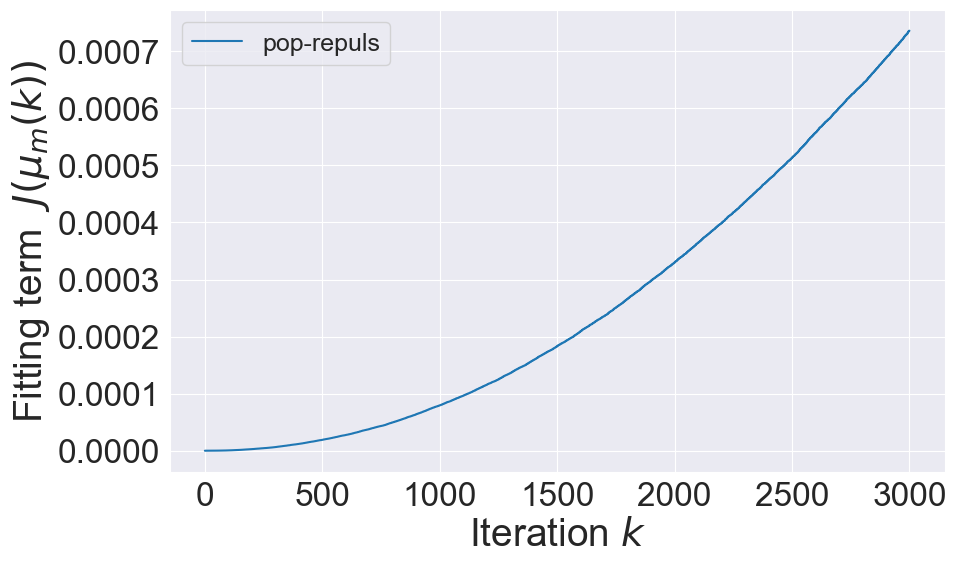

In [1119]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

plt.plot(np.arange(len(losses3)), losses3, label='pop-repuls')
#plt.plot(np.arange(len(losses_pop)), losses_pop, label='pop-conic')
#plt.plot(np.arange(len(train_losses_mix_conic)), train_losses_mix_conic, label='mix-conic')

plt.xlabel('Iteration $k$', fontsize=28)
plt.ylabel('Fitting term $\\ J(\\mu_m(k))$', fontsize=28)
#plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=18)
#plt.savefig(os.path.join(FIGURES_DIR, 'losses-ista-10-1.png'), bbox_inches='tight')
plt.show()

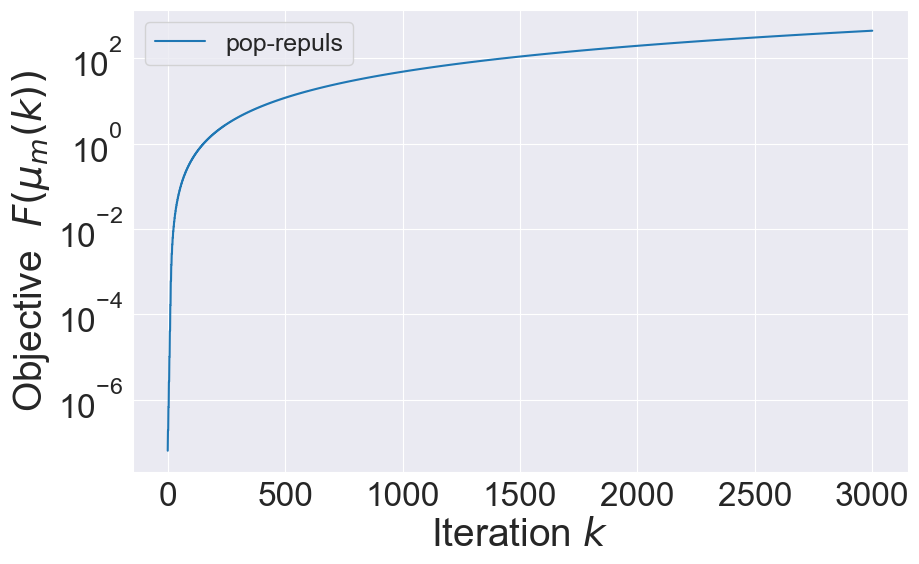

In [1120]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
plt.yscale('log')

plt.plot(np.arange(len(penalized_losses3)), penalized_losses3, label='pop-repuls')
#plt.plot(np.arange(len(penalized_losses_pop)), penalized_losses_pop, label='pop-conic')
#plt.plot(np.arange(len(penalized_train_losses_mix_conic)), penalized_train_losses_mix_conic, label='mix-conic')

plt.xlabel('Iteration $k$', fontsize=28)
plt.ylabel('Objective $\\ F(\\mu_m(k))$', fontsize=28)
#plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=18)
#plt.savefig(os.path.join(FIGURES_DIR, 'losses-ista-10-1.png'), bbox_inches='tight')
plt.show()

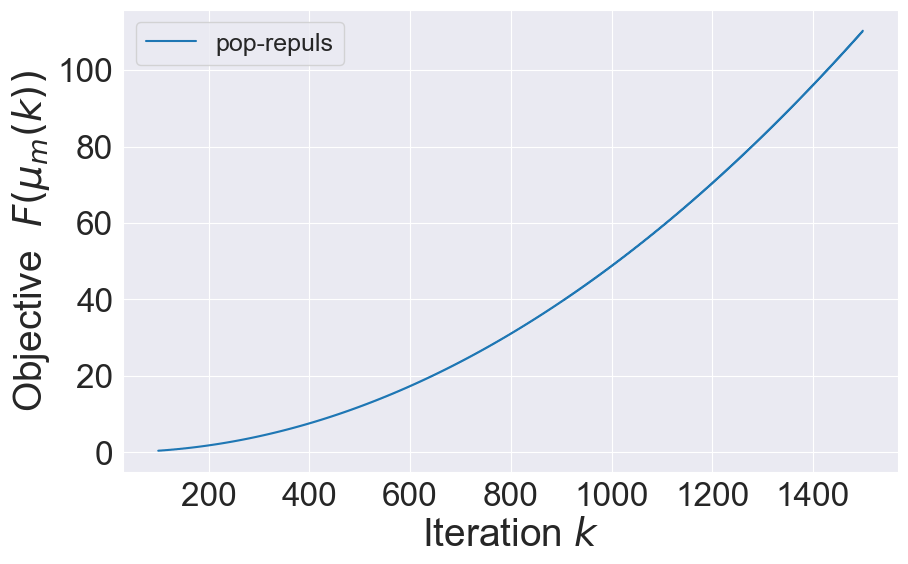

In [1121]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

k_min, k_max = 100, 1500

plt.plot(np.arange(len(penalized_losses3))[k_min:k_max], penalized_losses3[k_min:k_max], label='pop-repuls')
#plt.plot(np.arange(len(penalized_losses_pop)), penalized_losses_pop, label='pop-conic')
#plt.plot(np.arange(len(penalized_train_losses_mix_conic)), penalized_train_losses_mix_conic, label='mix-conic')

plt.xlabel('Iteration $k$', fontsize=28)
plt.ylabel('Objective $\\ F(\\mu_m(k))$', fontsize=28)
#plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=18)
#plt.savefig(os.path.join(FIGURES_DIR, 'losses-ista-10-1.png'), bbox_inches='tight')
plt.show()

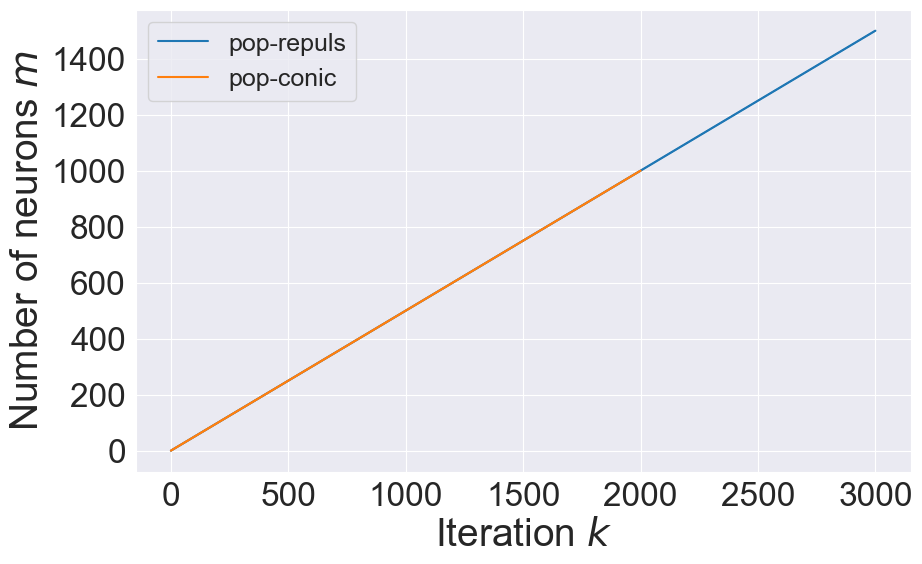

In [1122]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

plt.plot(np.arange(len(ms3)), ms3, label='pop-repuls')
plt.plot(np.arange(len(ms_pop)), ms_pop, label='pop-conic')

#plt.plot(np.arange(len(ms_mix_conic)), ms_mix_conic, label='mix-conic')

plt.xlabel('Iteration $k$', fontsize=28)
plt.ylabel('Number of neurons $m$', fontsize=28)
#plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=18)
#plt.savefig(os.path.join(FIGURES_DIR, 'losses-ista-10-1.png'), bbox_inches='tight')
plt.show()

In [556]:
# REPULSIVE makes more sense as the pop step does not increase the penalized loss
ETA = 0.07
sigma = 2.0 # 0.3
N_STEPS = 9000 #3000
eps = 0.6 # 0.6
n_updates = 3

TAU = 1.0
ALPHA = 1.0 ## ---> CRUCIAL !!
LAMBDA = 0.008 # 1.0

kappa = 'kappa_1'

# POP ONLY NO PENALTY
pop_penalty = False
dynamic = False
pop = True
conic = False
penalty = False
c0_, u0_ = add_neuron(None, None, x_train, y_train, kappa)
c, u, losses_pop_only, penalized_losses_pop_only, ms_pop_only, _ = \
        train(c0_, u0_, kappa=kappa, sigma=sigma, eps=eps, n_updates=n_updates, 
              conic=conic, dynamic=dynamic, pop_penalty=pop_penalty, pop=pop, penalty=penalty)

# POP-CONIC-PENALTY
pop_penalty = False
dynamic = True
pop = True
conic = True
penalty = True
c0_, u0_ = add_neuron(None, None, x_train, y_train, kappa)
c, u, losses3, penalized_losses3, ms3, _ = \
        train(c0_, u0_, kappa=kappa, sigma=sigma, eps=eps, n_updates=n_updates, 
              conic=conic, dynamic=dynamic, pop_penalty=pop_penalty, pop=pop, penalty=penalty)
#        train(c0, u0, kappa='kappa_1', sigma=sigma, eps=eps, dynamic=dynamic, n_updates=n_updates, penalty=penalty)

# POP-CONIC
pop_penalty = False
dynamic = True
pop = True
conic = True
penalty = False
c, u, losses_pop, penalized_losses_pop, ms_pop, _ = \
        train(c0_, u0_, kappa=kappa, sigma=sigma, eps=eps, n_updates=n_updates, 
              conic=conic, dynamic=dynamic, pop_penalty=pop_penalty, pop=pop, penalty=penalty)

# CONIC
pop_penalty = False
dynamic = False
pop = False
conic = True
penalty = False
m = 256
signs = np.sign(np.random.normal(size=(1, m)))
c0 = signs / m

u0 = np.random.normal(size=(m, INPUT_DIM))
u0 = u0 / np.linalg.norm(u0, axis=1, ord=2, keepdims=True)

c, u, losses, penalized_losses, ms, _ = \
        train(c0, u0, kappa=kappa, sigma=sigma, eps=eps, n_updates=n_updates, 
              conic=conic, dynamic=dynamic, pop_penalty=pop_penalty, pop=pop, penalty=penalty)

# CONIC-PENALTY
#dynamic = False
#conic=False
#pop = False
#c, u, losses_pen, penalized_losses_pen, grads, ms, _ = \
#        train(c0, u0, kappa='kappa_3', sigma=sigma, eps=eps, dynamic=dynamic, n_updates=n_updates, penalty=penalty,
#              conic=conic, pop=pop)

# CONIC-DYNAMIC
pop_penalty = False
dynamic = True
pop = False
conic = True
penalty = False
m = 256
c, u, losses_dyn, penalized_losses_dyn, ms_dyn, _ = \
        train(c0, u0, kappa=kappa, sigma=sigma, eps=eps, n_updates=n_updates, 
              conic=conic, dynamic=dynamic, pop_penalty=pop_penalty, pop=pop, penalty=penalty)

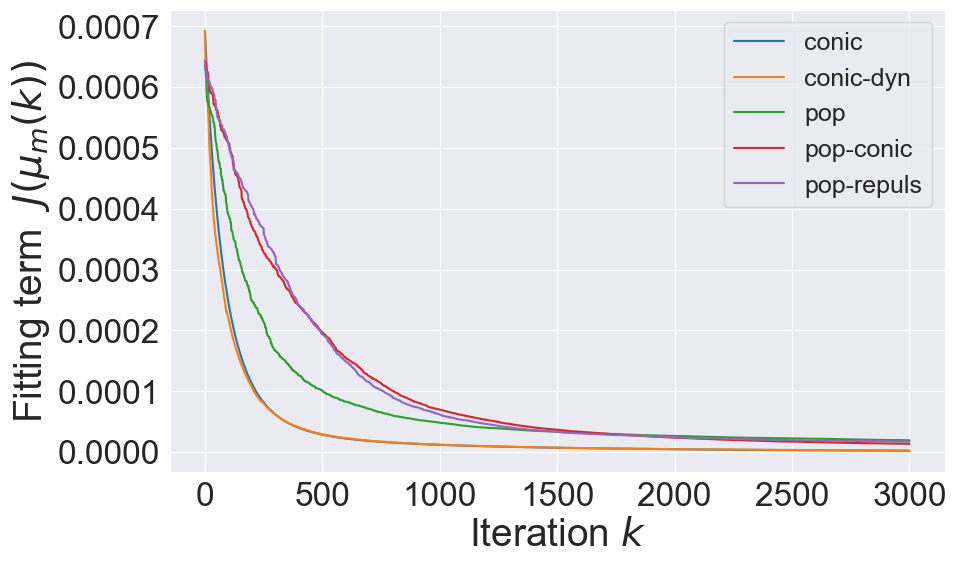

In [557]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

plt.plot(np.arange(len(losses)), losses, label='conic')
plt.plot(np.arange(len(losses_dyn)), losses_dyn, label='conic-dyn')
plt.plot(np.arange(len(losses_pop_only)), losses_pop_only, label='pop')
plt.plot(np.arange(len(losses_pop)), losses_pop, label='pop-conic')
plt.plot(np.arange(len(losses3)), losses3, label='pop-repuls')
#plt.plot(np.arange(len(train_losses_mix_conic)), train_losses_mix_conic, label='mix-conic')

plt.xlabel('Iteration $k$', fontsize=28)
plt.ylabel('Fitting term $\\ J(\\mu_m(k))$', fontsize=28)
#plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=18)
#plt.savefig(os.path.join(FIGURES_DIR, 'losses-ista-10-1.png'), bbox_inches='tight')
plt.show()

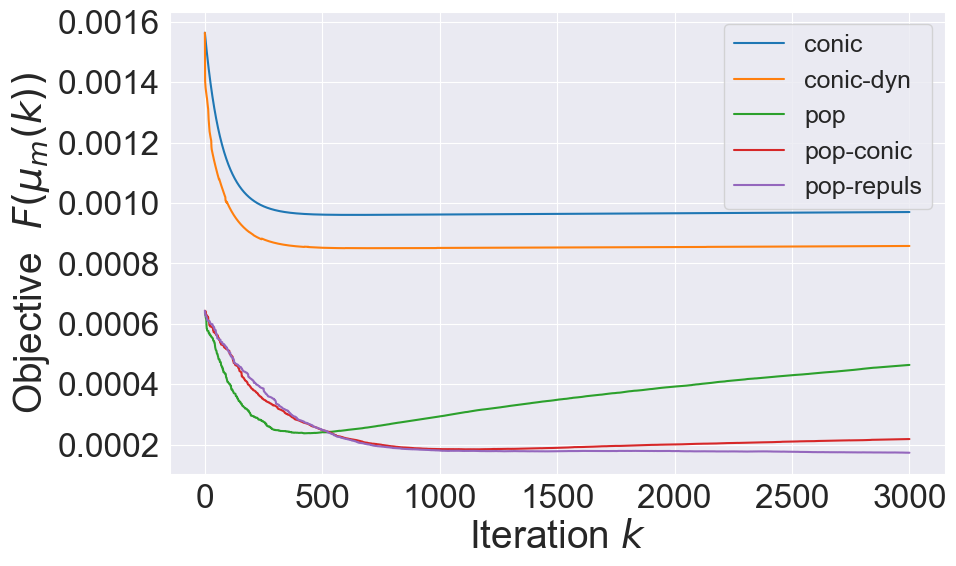

In [558]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

plt.plot(np.arange(len(penalized_losses)), penalized_losses, label='conic')
plt.plot(np.arange(len(penalized_losses_dyn)), penalized_losses_dyn, label='conic-dyn')
plt.plot(np.arange(len(penalized_losses_pop_only)), penalized_losses_pop_only, label='pop')
plt.plot(np.arange(len(penalized_losses_pop)), penalized_losses_pop, label='pop-conic')
plt.plot(np.arange(len(penalized_losses3)), penalized_losses3, label='pop-repuls')
#plt.plot(np.arange(len(penalized_train_losses_mix_conic)), penalized_train_losses_mix_conic, label='mix-conic')

plt.xlabel('Iteration $k$', fontsize=28)
plt.ylabel('Objective $\\ F(\\mu_m(k))$', fontsize=28)
#plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=18)
#plt.savefig(os.path.join(FIGURES_DIR, 'losses-ista-10-1.png'), bbox_inches='tight')
plt.show()

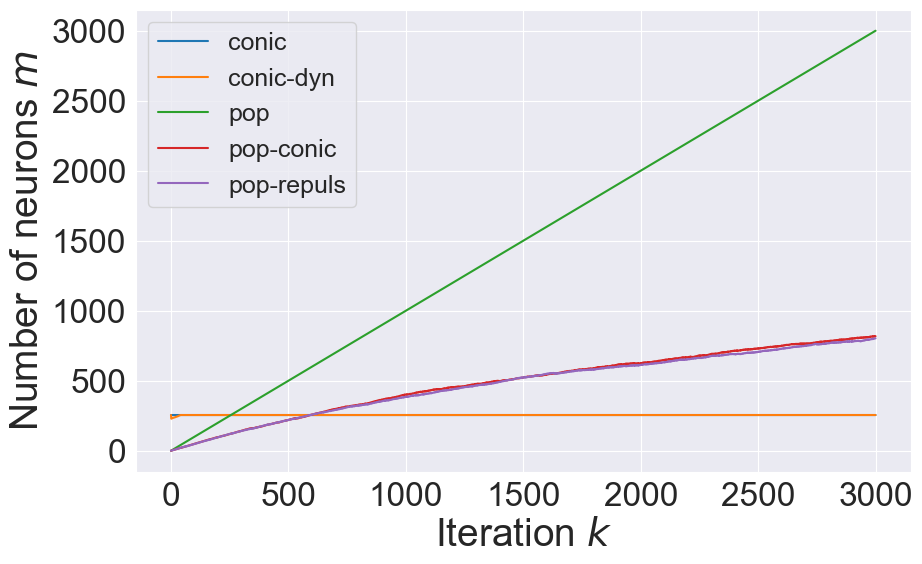

In [559]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

plt.plot(np.arange(len(ms)), ms, label='conic')
plt.plot(np.arange(len(ms_dyn)), ms_dyn, label='conic-dyn')
plt.plot(np.arange(len(ms_pop_only)), ms_pop_only, label='pop')
plt.plot(np.arange(len(ms_pop)), ms_pop, label='pop-conic')
plt.plot(np.arange(len(ms3)), ms3, label='pop-repuls')
#plt.plot(np.arange(len(ms_mix_conic)), ms_mix_conic, label='mix-conic')

plt.xlabel('Iteration $k$', fontsize=28)
plt.ylabel('Number of neurons $m$', fontsize=28)
#plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=18)
#plt.savefig(os.path.join(FIGURES_DIR, 'losses-ista-10-1.png'), bbox_inches='tight')
plt.show()

## 2. Mix pop-conic with $L^1$-proximal algorithm

In [560]:
def compute_losses(a, b, x, y, penalized=True):
    y_hat = forward(a, b, x)
    loss_ = 0.5 * np.mean((y_hat - y)**2)
    if penalized:
        penalized_loss = loss_ + LAMBDA * np.sum(np.abs(a))
    else:
        penalized_loss = 0.
    return loss_, penalized_loss

In [561]:
def soft_thresholding(V, tau):
    return - np.sign(V) * np.maximum(0, np.abs(V) - tau)

In [562]:
def V_grad(a, b, x, y, new_b):
    y_hat = forward(a, b, x)
    if len(new_b.shape) < 2:
        new_b = new_b.reshape(1, -1)
    V_grad_ = np.mean((y_hat - y) * np.maximum(np.matmul(x, new_b.T), 0), axis=0)
    if len(V_grad_) == 1:
        return V_grad_[0]
    else:
        return V_grad_

In [563]:
def nabla_V_grad(a, b, x, y, factor=1.0):
    n = len(x)
    m = a.shape[1]
    y_hat = forward(a, b, x)
    # M = (y_hat - y) * np.heaviside(np.matmul(x, b.T * a), 0)
    M = (y_hat - y) * np.heaviside(np.matmul(x, b.T), 0) * factor
    return np.matmul(M.T, x) / n    

In [564]:
def projected_conic_particle_update(c, u, x, y, penalized=False):
    m = c.shape[1]
    if m > 0:
        signs = np.sign(c)
        c = c * (1 - 2 * ETA * signs * V_grad(c, u, x, y, u).reshape(1, -1))
        u = u - ETA * signs.T * nabla_V_grad(c, u, x, y)
        
        if penalized:
            c -= 2 * ETA * LAMBDA * c
            u -= ETA * LAMBDA * u
        
        u_norms = np.linalg.norm(u, ord=2, axis=1, keepdims=True)
        u = u / u_norms
    return c, u  

In [565]:
def add_new_neuron(c, u, x, y, eps=1.0e-6):
    new_u = np.random.normal(size=(1, INPUT_DIM))
    neuron_scale = np.linalg.norm(new_u, axis=1, ord=2)
    new_u = new_u / neuron_scale
    V = V_grad(c, u, x, y, new_u)
    new_c = ALPHA * soft_thresholding(V, tau=LAMBDA)
    
    if np.abs(new_c) > eps:
        if c.shape[1] == 0:
            c = np.array([[new_c]])
            u = new_u
        else:
            c = np.column_stack((c, [new_c]))
            u = np.row_stack((u, new_u))
    
    return c, u 

In [566]:
def update_random_neuron(c, u, x, y, eps=1.0e-9):
    if c.shape[1] > 0:
        j = np.random.randint(low=0, high=c.shape[1])
        u_j = u[j, :].reshape(1, -1)
        V = V_grad(c, u, x, y, u_j) - c[0, j] / BETA 
        new_c = BETA * soft_thresholding(V, tau=LAMBDA)

        if np.abs(new_c) > 0:
            # update weight for neuron b_j
            c[0, j] = new_c  
        else:
            # remove a_j and b_j from the list
            c = np.column_stack((c[:, :j], c[:, j+1:]))
            u = np.row_stack((u[:j, :], u[j+1:, :]))
        #    a[0, j] = 0. 
    return c, u  

In [567]:
def train(c, u, n_steps, x_train, y_train, x_val, y_val, do_val=True, penalized=False):
    ms = [1]
    train_losses = []
    penalized_train_losses = []
    val_losses = []
    penalized_val_losses = []

    for k in tqdm(range(n_steps)):
        if k % 3 == 0:
            # sample new particle and set weight
            c, u = add_new_neuron(c, u, x_train, y_train, eps=1e-8)
            ms.append(c.shape[1])
            # compute training loss
            train_loss, penalized_train_loss = compute_losses(c, u, x_train, y_train)
            train_losses.append(train_loss)
            penalized_train_losses.append(penalized_train_loss)
        elif k % 3 == 1:
            # update existing particle
            c, u = update_random_neuron(c, u, x_train, y_train, eps=1e-8)
            ms.append(c.shape[1])
            # compute training loss
            train_loss, penalized_train_loss = compute_losses(c, u, x_train, y_train)
            train_losses.append(train_loss)
            penalized_train_losses.append(penalized_train_loss)
        else:
            # do conic-GD update
            c, u = projected_conic_particle_update(c, u, x_train, y_train, penalized=penalized)
            ms.append(c.shape[1])
            # compute training loss
            train_loss, penalized_train_loss = compute_losses(c, u, x_train, y_train)
            train_losses.append(train_loss)
            penalized_train_losses.append(penalized_train_loss)
        
        # validation loop if do_val is True
        if do_val:
            if k % VAL_ITER == 0:
                val_loss, penalized_val_loss = compute_losses(c, u, x_val, y_val)
                val_losses.append(val_loss)
                penalized_val_losses.append(penalized_val_loss)
                print('m at step {:,} : {:,}'.format(k, ms[-1]))
                print('Train loss at step {:,} : {:.5f}'.format(k, train_loss))
                print('Validation loss at step {:,} : {:.5f}'.format(k, val_loss))
                
    return c, u, np.array(ms), np.array(train_losses), np.array(penalized_train_losses), np.array(val_losses), \
           np.array(penalized_val_losses) 

In [568]:
EPS = 1.0e-7
ALPHA = 1.0
BETA = 1.0
LAMBDA = 0.0001
n_steps = N_STEPS
penalized = True

c, u, ms_mix_conic, train_losses_mix_conic, penalized_train_losses_mix_conic, val_losses, penalized_val_losses = \
        train(c0_, u0_, n_steps, x_train, y_train, x_val, y_val, penalized=penalized)

  5%|███▍                                                             | 477/9000 [00:00<00:01, 4754.97it/s]

m at step 0 : 2
Train loss at step 0 : 0.00064
Validation loss at step 0 : 0.00076
m at step 100 : 33
Train loss at step 100 : 0.00047
Validation loss at step 100 : 0.00060
m at step 200 : 62
Train loss at step 200 : 0.00038
Validation loss at step 200 : 0.00051
m at step 300 : 93
Train loss at step 300 : 0.00028
Validation loss at step 300 : 0.00042
m at step 400 : 123
Train loss at step 400 : 0.00021
Validation loss at step 400 : 0.00034
m at step 500 : 152
Train loss at step 500 : 0.00017
Validation loss at step 500 : 0.00030
m at step 600 : 179
Train loss at step 600 : 0.00014
Validation loss at step 600 : 0.00026
m at step 700 : 205
Train loss at step 700 : 0.00012
Validation loss at step 700 : 0.00024
m at step 800 : 233
Train loss at step 800 : 0.00010
Validation loss at step 800 : 0.00021


 15%|█████████▋                                                      | 1354/9000 [00:00<00:02, 3300.99it/s]

m at step 900 : 261
Train loss at step 900 : 0.00008
Validation loss at step 900 : 0.00019
m at step 1,000 : 286
Train loss at step 1,000 : 0.00008
Validation loss at step 1,000 : 0.00018
m at step 1,100 : 313
Train loss at step 1,100 : 0.00007
Validation loss at step 1,100 : 0.00017
m at step 1,200 : 339
Train loss at step 1,200 : 0.00006
Validation loss at step 1,200 : 0.00016
m at step 1,300 : 367
Train loss at step 1,300 : 0.00006
Validation loss at step 1,300 : 0.00016
m at step 1,400 : 387
Train loss at step 1,400 : 0.00005
Validation loss at step 1,400 : 0.00015


 19%|████████████                                                    | 1696/9000 [00:00<00:02, 2903.30it/s]

m at step 1,500 : 408
Train loss at step 1,500 : 0.00005
Validation loss at step 1,500 : 0.00014
m at step 1,600 : 429
Train loss at step 1,600 : 0.00005
Validation loss at step 1,600 : 0.00014
m at step 1,700 : 455
Train loss at step 1,700 : 0.00005
Validation loss at step 1,700 : 0.00014
m at step 1,800 : 470
Train loss at step 1,800 : 0.00004
Validation loss at step 1,800 : 0.00014
m at step 1,900 : 486
Train loss at step 1,900 : 0.00004
Validation loss at step 1,900 : 0.00013


 25%|████████████████                                                | 2267/9000 [00:00<00:02, 2429.66it/s]

m at step 2,000 : 504
Train loss at step 2,000 : 0.00004
Validation loss at step 2,000 : 0.00013
m at step 2,100 : 517
Train loss at step 2,100 : 0.00004
Validation loss at step 2,100 : 0.00013
m at step 2,200 : 536
Train loss at step 2,200 : 0.00004
Validation loss at step 2,200 : 0.00013
m at step 2,300 : 552
Train loss at step 2,300 : 0.00004
Validation loss at step 2,300 : 0.00013
m at step 2,400 : 563
Train loss at step 2,400 : 0.00003
Validation loss at step 2,400 : 0.00013


 30%|███████████████████▌                                            | 2745/9000 [00:01<00:02, 2156.43it/s]

m at step 2,500 : 576
Train loss at step 2,500 : 0.00003
Validation loss at step 2,500 : 0.00012
m at step 2,600 : 590
Train loss at step 2,600 : 0.00003
Validation loss at step 2,600 : 0.00012
m at step 2,700 : 604
Train loss at step 2,700 : 0.00003
Validation loss at step 2,700 : 0.00012
m at step 2,800 : 618
Train loss at step 2,800 : 0.00003
Validation loss at step 2,800 : 0.00012


 35%|██████████████████████▌                                         | 3168/9000 [00:01<00:02, 1962.76it/s]

m at step 2,900 : 627
Train loss at step 2,900 : 0.00003
Validation loss at step 2,900 : 0.00012
m at step 3,000 : 641
Train loss at step 3,000 : 0.00003
Validation loss at step 3,000 : 0.00012
m at step 3,100 : 654
Train loss at step 3,100 : 0.00003
Validation loss at step 3,100 : 0.00012
m at step 3,200 : 660
Train loss at step 3,200 : 0.00003
Validation loss at step 3,200 : 0.00012


 39%|█████████████████████████▎                                      | 3553/9000 [00:01<00:02, 1850.16it/s]

m at step 3,300 : 666
Train loss at step 3,300 : 0.00003
Validation loss at step 3,300 : 0.00012
m at step 3,400 : 680
Train loss at step 3,400 : 0.00003
Validation loss at step 3,400 : 0.00011
m at step 3,500 : 686
Train loss at step 3,500 : 0.00002
Validation loss at step 3,500 : 0.00011
m at step 3,600 : 690
Train loss at step 3,600 : 0.00002
Validation loss at step 3,600 : 0.00011


 44%|████████████████████████████                                    | 3942/9000 [00:01<00:02, 1894.89it/s]

m at step 3,700 : 699
Train loss at step 3,700 : 0.00002
Validation loss at step 3,700 : 0.00011
m at step 3,800 : 709
Train loss at step 3,800 : 0.00002
Validation loss at step 3,800 : 0.00011
m at step 3,900 : 715
Train loss at step 3,900 : 0.00002
Validation loss at step 3,900 : 0.00011
m at step 4,000 : 724
Train loss at step 4,000 : 0.00002
Validation loss at step 4,000 : 0.00011
m at step 4,100 : 730
Train loss at step 4,100 : 0.00002
Validation loss at step 4,100 : 0.00011


 50%|████████████████████████████████▏                               | 4521/9000 [00:02<00:02, 1913.69it/s]

m at step 4,200 : 734
Train loss at step 4,200 : 0.00002
Validation loss at step 4,200 : 0.00011
m at step 4,300 : 742
Train loss at step 4,300 : 0.00002
Validation loss at step 4,300 : 0.00011
m at step 4,400 : 749
Train loss at step 4,400 : 0.00002
Validation loss at step 4,400 : 0.00011
m at step 4,500 : 752
Train loss at step 4,500 : 0.00002
Validation loss at step 4,500 : 0.00011


 55%|██████████████████████████████████▉                             | 4905/9000 [00:02<00:02, 1891.14it/s]

m at step 4,600 : 754
Train loss at step 4,600 : 0.00002
Validation loss at step 4,600 : 0.00011
m at step 4,700 : 759
Train loss at step 4,700 : 0.00002
Validation loss at step 4,700 : 0.00010
m at step 4,800 : 765
Train loss at step 4,800 : 0.00002
Validation loss at step 4,800 : 0.00010
m at step 4,900 : 769
Train loss at step 4,900 : 0.00002
Validation loss at step 4,900 : 0.00010


 59%|█████████████████████████████████████▌                          | 5286/9000 [00:02<00:02, 1853.10it/s]

m at step 5,000 : 773
Train loss at step 5,000 : 0.00002
Validation loss at step 5,000 : 0.00010
m at step 5,100 : 774
Train loss at step 5,100 : 0.00002
Validation loss at step 5,100 : 0.00010
m at step 5,200 : 780
Train loss at step 5,200 : 0.00002
Validation loss at step 5,200 : 0.00010
m at step 5,300 : 781
Train loss at step 5,300 : 0.00002
Validation loss at step 5,300 : 0.00010


 63%|████████████████████████████████████████▏                       | 5660/9000 [00:02<00:01, 1825.94it/s]

m at step 5,400 : 786
Train loss at step 5,400 : 0.00002
Validation loss at step 5,400 : 0.00010
m at step 5,500 : 794
Train loss at step 5,500 : 0.00002
Validation loss at step 5,500 : 0.00010
m at step 5,600 : 795
Train loss at step 5,600 : 0.00002
Validation loss at step 5,600 : 0.00010
m at step 5,700 : 794
Train loss at step 5,700 : 0.00002
Validation loss at step 5,700 : 0.00010


 67%|██████████████████████████████████████████▊                     | 6028/9000 [00:02<00:01, 1809.98it/s]

m at step 5,800 : 798
Train loss at step 5,800 : 0.00002
Validation loss at step 5,800 : 0.00010
m at step 5,900 : 799
Train loss at step 5,900 : 0.00002
Validation loss at step 5,900 : 0.00010
m at step 6,000 : 800
Train loss at step 6,000 : 0.00002
Validation loss at step 6,000 : 0.00010
m at step 6,100 : 799
Train loss at step 6,100 : 0.00002
Validation loss at step 6,100 : 0.00010


 71%|█████████████████████████████████████████████▍                  | 6395/9000 [00:03<00:01, 1803.76it/s]

m at step 6,200 : 806
Train loss at step 6,200 : 0.00002
Validation loss at step 6,200 : 0.00010
m at step 6,300 : 806
Train loss at step 6,300 : 0.00001
Validation loss at step 6,300 : 0.00010
m at step 6,400 : 813
Train loss at step 6,400 : 0.00001
Validation loss at step 6,400 : 0.00010
m at step 6,500 : 813
Train loss at step 6,500 : 0.00001
Validation loss at step 6,500 : 0.00010


 77%|█████████████████████████████████████████████████▍              | 6945/9000 [00:03<00:01, 1795.37it/s]

m at step 6,600 : 812
Train loss at step 6,600 : 0.00001
Validation loss at step 6,600 : 0.00010
m at step 6,700 : 815
Train loss at step 6,700 : 0.00001
Validation loss at step 6,700 : 0.00010
m at step 6,800 : 815
Train loss at step 6,800 : 0.00001
Validation loss at step 6,800 : 0.00010
m at step 6,900 : 813
Train loss at step 6,900 : 0.00001
Validation loss at step 6,900 : 0.00010


 81%|███████████████████████████████████████████████████▉            | 7308/9000 [00:03<00:00, 1795.45it/s]

m at step 7,000 : 813
Train loss at step 7,000 : 0.00001
Validation loss at step 7,000 : 0.00010
m at step 7,100 : 814
Train loss at step 7,100 : 0.00001
Validation loss at step 7,100 : 0.00010
m at step 7,200 : 814
Train loss at step 7,200 : 0.00001
Validation loss at step 7,200 : 0.00010
m at step 7,300 : 812
Train loss at step 7,300 : 0.00001
Validation loss at step 7,300 : 0.00010


 85%|██████████████████████████████████████████████████████▌         | 7668/9000 [00:03<00:00, 1776.18it/s]

m at step 7,400 : 815
Train loss at step 7,400 : 0.00001
Validation loss at step 7,400 : 0.00010
m at step 7,500 : 813
Train loss at step 7,500 : 0.00001
Validation loss at step 7,500 : 0.00010
m at step 7,600 : 813
Train loss at step 7,600 : 0.00001
Validation loss at step 7,600 : 0.00009
m at step 7,700 : 810
Train loss at step 7,700 : 0.00001
Validation loss at step 7,700 : 0.00009


 89%|█████████████████████████████████████████████████████████       | 8030/9000 [00:03<00:00, 1776.00it/s]

m at step 7,800 : 811
Train loss at step 7,800 : 0.00001
Validation loss at step 7,800 : 0.00009
m at step 7,900 : 814
Train loss at step 7,900 : 0.00001
Validation loss at step 7,900 : 0.00009
m at step 8,000 : 814
Train loss at step 8,000 : 0.00001
Validation loss at step 8,000 : 0.00009
m at step 8,100 : 814
Train loss at step 8,100 : 0.00001
Validation loss at step 8,100 : 0.00009


 93%|███████████████████████████████████████████████████████████▋    | 8394/9000 [00:04<00:00, 1781.39it/s]

m at step 8,200 : 813
Train loss at step 8,200 : 0.00001
Validation loss at step 8,200 : 0.00009
m at step 8,300 : 811
Train loss at step 8,300 : 0.00001
Validation loss at step 8,300 : 0.00009
m at step 8,400 : 809
Train loss at step 8,400 : 0.00001
Validation loss at step 8,400 : 0.00009
m at step 8,500 : 809
Train loss at step 8,500 : 0.00001
Validation loss at step 8,500 : 0.00009


 99%|███████████████████████████████████████████████████████████████▌| 8946/9000 [00:04<00:00, 1812.09it/s]

m at step 8,600 : 810
Train loss at step 8,600 : 0.00001
Validation loss at step 8,600 : 0.00009
m at step 8,700 : 808
Train loss at step 8,700 : 0.00001
Validation loss at step 8,700 : 0.00009
m at step 8,800 : 807
Train loss at step 8,800 : 0.00001
Validation loss at step 8,800 : 0.00009
m at step 8,900 : 811
Train loss at step 8,900 : 0.00001
Validation loss at step 8,900 : 0.00009


100%|████████████████████████████████████████████████████████████████| 9000/9000 [00:04<00:00, 1986.27it/s]


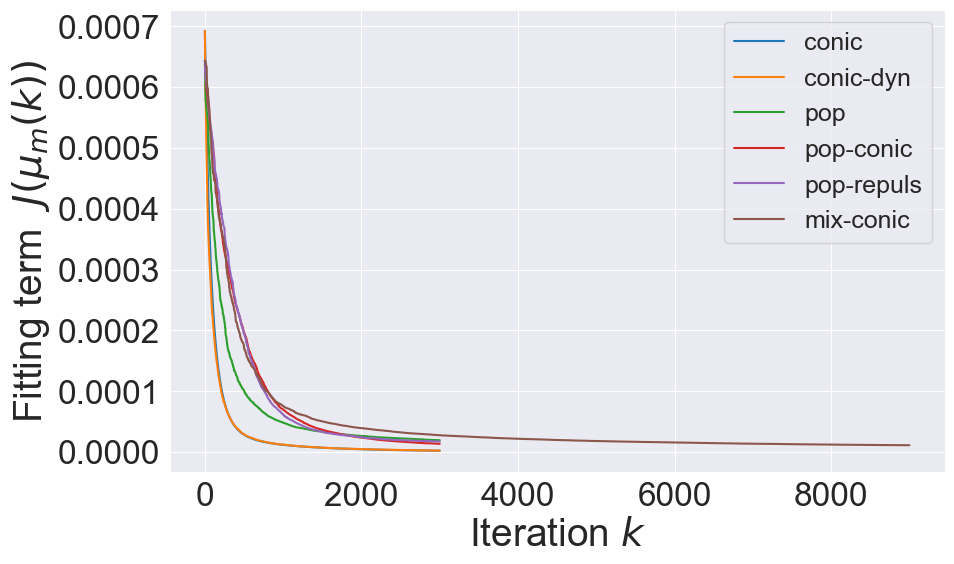

In [569]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

plt.plot(np.arange(len(losses)), losses, label='conic')
plt.plot(np.arange(len(losses_dyn)), losses_dyn, label='conic-dyn')
plt.plot(np.arange(len(losses_pop_only)), losses_pop_only, label='pop')
plt.plot(np.arange(len(losses_pop)), losses_pop, label='pop-conic')
plt.plot(np.arange(len(losses3)), losses3, label='pop-repuls')
plt.plot(np.arange(len(train_losses_mix_conic)), train_losses_mix_conic, label='mix-conic')

plt.xlabel('Iteration $k$', fontsize=28)
plt.ylabel('Fitting term $\\ J(\\mu_m(k))$', fontsize=28)
#plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=18)
#plt.savefig(os.path.join(FIGURES_DIR, 'losses-ista-10-1.png'), bbox_inches='tight')
plt.show()

In [570]:
print(np.min(losses))
print(np.min(losses_dyn))
print(np.min(losses_pop))
print(np.min(losses3))

2.202108850858785e-06
2.382526512088738e-06
1.3548296055153691e-05
1.736465521710598e-05


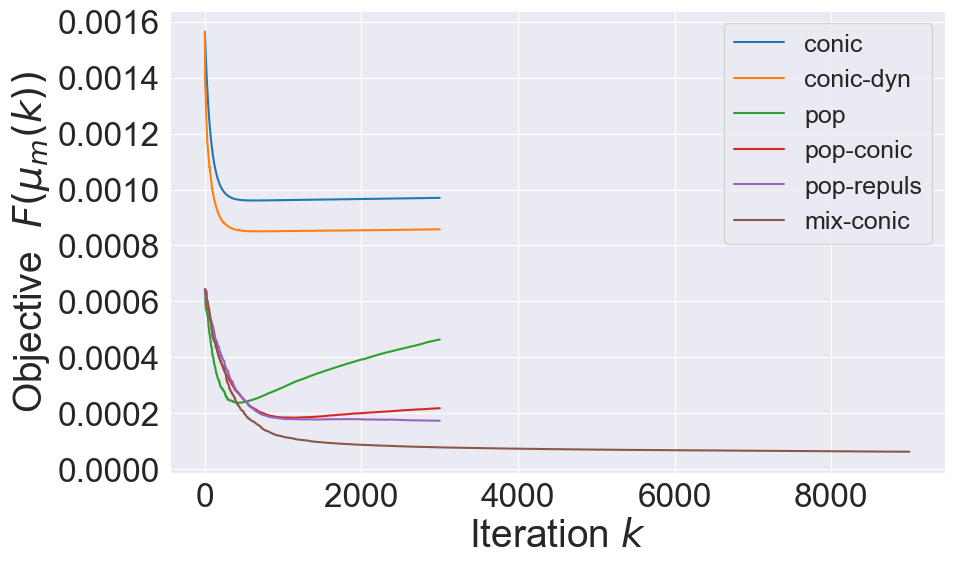

In [571]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

plt.plot(np.arange(len(penalized_losses)), penalized_losses, label='conic')
plt.plot(np.arange(len(penalized_losses_dyn)), penalized_losses_dyn, label='conic-dyn')
plt.plot(np.arange(len(penalized_losses_pop_only)), penalized_losses_pop_only, label='pop')
plt.plot(np.arange(len(penalized_losses_pop)), penalized_losses_pop, label='pop-conic')
plt.plot(np.arange(len(penalized_losses3)), penalized_losses3, label='pop-repuls')
plt.plot(np.arange(len(penalized_train_losses_mix_conic)), penalized_train_losses_mix_conic, label='mix-conic')

plt.xlabel('Iteration $k$', fontsize=28)
plt.ylabel('Objective $\\ F(\\mu_m(k))$', fontsize=28)
#plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=18)
#plt.savefig(os.path.join(FIGURES_DIR, 'losses-ista-10-1.png'), bbox_inches='tight')
plt.show()

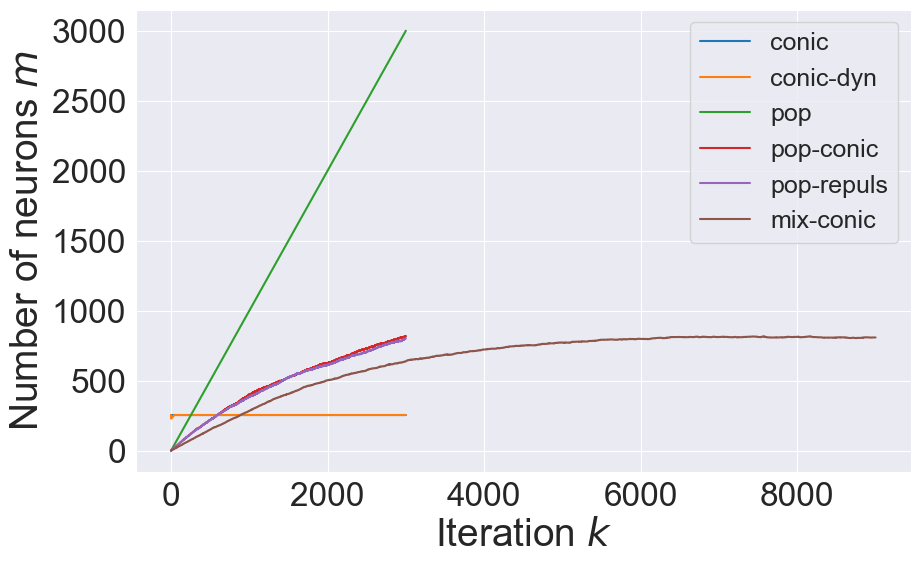

In [572]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

plt.plot(np.arange(len(ms)), ms, label='conic')
plt.plot(np.arange(len(ms_dyn)), ms_dyn, label='conic-dyn')
plt.plot(np.arange(len(ms_pop_only)), ms_pop_only, label='pop')
plt.plot(np.arange(len(ms_pop)), ms_pop, label='pop-conic')
plt.plot(np.arange(len(ms3)), ms3, label='pop-repuls')
plt.plot(np.arange(len(ms_mix_conic)), ms_mix_conic, label='mix-conic')

plt.xlabel('Iteration $k$', fontsize=28)
plt.ylabel('Number of neurons $m$', fontsize=28)
#plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=18)
#plt.savefig(os.path.join(FIGURES_DIR, 'losses-ista-10-1.png'), bbox_inches='tight')
plt.show()

In [573]:
np.array(ms_dyn)[np.array(ms_dyn) < 256]

array([230, 230, 231, 232, 233, 234, 235, 236, 236, 236, 237, 237, 238,
       239, 239, 239, 240, 241, 241, 242, 243, 243, 244, 245, 245, 246,
       246, 246, 247, 248, 249, 250, 251, 252, 252, 253, 253, 254, 255])

In [574]:
ms_mix_conic[-20:]

array([810, 810, 810, 810, 810, 810, 810, 810, 810, 810, 810, 810, 810,
       810, 810, 810, 810, 810, 810, 810])

In [575]:
np.min(losses_pop)

1.3548296055153691e-05

In [576]:
np.min(losses3)

1.736465521710598e-05

In [577]:
np.min(train_losses_mix_conic)

1.12121920623006e-05

In [259]:
ms_pop[-20:]

[999,
 998,
 999,
 999,
 1000,
 999,
 1000,
 999,
 1000,
 1000,
 1001,
 1000,
 1001,
 1001,
 1002,
 1001,
 1002,
 1002,
 1003,
 1003]